# Clause Clustering Using Embedding Vectors

## Introduction

In this notebook, we group semantically similar legal clauses using unsupervised **clustering**. Leveraging high-dimensional **clause embeddings** generated via sentence-transformers (e.g., SBERT), we aim to discover patterns, themes, or categories that are not explicitly labeled.

This approach enables:
- Clause exploration and grouping
- Pattern discovery in large-scale contract datasets
- Visualization of latent semantic structure

---

## Objectives

- Load precomputed clause embeddings from disk (`.npy` + metadata).
- Normalize and optionally reduce dimensionality for clustering.
- Apply clustering algorithms (KMeans, HDBSCAN).
- Evaluate clustering structure and analyze content of discovered groups.
- Visualize clusters using UMAP or t-SNE in 2D.

> **Input Files:**  
> - `results/clause_embeddings.npy`  
> - `results/clause_metadata.pkl`  
>  
> **Output (optional):** Clustered clauses exported as CSV for downstream use.

---

## Steps in This Notebook

1. **Load Clause Embeddings**
   - Load `.npy` file (embeddings) and `.pkl` (text, labels).

2. **Preprocessing for Clustering**
   - Normalize embeddings.
   - Optionally reduce dimensions with PCA.

3. **Apply Clustering Algorithms**
   - Run K-Means and/or HDBSCAN on embeddings.
   - Assign cluster labels.

4. **Cluster Analysis**
   - Analyze top clusters and label distributions.
   - Display sample clauses per cluster.

5. **Visualize Clusters in 2D**
   - Use UMAP or t-SNE to plot clause embeddings by cluster.

6. **(Optional) Save Clustered Clauses**
   - Export cluster assignments + text/metadata to CSV.

---

## Step 1: Load Precomputed Clause Embeddings

We begin by loading:

- `clause_embeddings.npy`: Precomputed 384-dim SBERT vectors
- `clause_metadata.pkl`: Dictionary of clause texts and cleaned clause types

These were generated in the previous notebook (`02_clause_embedding_and_search.ipynb`) and are used as input for clustering.


In [1]:
from pathlib import Path
import numpy as np
import pickle
import pandas as pd

# — Determine project root & paths —
BASE_DIR       = Path.cwd().parent
EMBED_NPY_PATH = BASE_DIR / "results" / "clause_embeddings.npy"
META_PATH      = BASE_DIR / "results" / "clause_metadata.pkl"

# 1) Load the NumPy embeddings
if not EMBED_NPY_PATH.exists():
    raise FileNotFoundError(f"Embedding array not found: {EMBED_NPY_PATH.resolve()}")
clause_embeddings = np.load(EMBED_NPY_PATH)
print(f"Loaded embeddings array: shape {clause_embeddings.shape}")

# 2) Load metadata (texts & labels)
if not META_PATH.exists():
    raise FileNotFoundError(f"Metadata file not found: {META_PATH.resolve()}")
with open(META_PATH, "rb") as f:
    metadata = pickle.load(f)
clause_texts = metadata["clause_text"]
clause_labels = metadata["cleaned_type"]

print(f"Loaded metadata: {len(clause_texts)} clauses, {len(clause_labels)} labels")


Loaded embeddings array: shape (13809, 384)
Loaded metadata: 13809 clauses, 13809 labels


---

## Step 2: Preprocessing for Clustering

Before clustering, we:

1. **Normalize** the 384-dimensional embeddings to unit vectors (L2 norm), which is required when using cosine-based metrics.  
2. **Optionally** reduce dimensionality via PCA (e.g. to 50 components) to speed up clustering and remove noise.  

You can disable PCA by setting `APPLY_PCA = False` if you prefer to cluster in the full space.

---


In [2]:
from pathlib import Path
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

# 1) Normalize to unit length
embeddings_norm = normalize(clause_embeddings, norm="l2")
print(f"Normalized embeddings shape: {embeddings_norm.shape}")

# 2) PCA reduction (optional)
APPLY_PCA      = True
PCA_COMPONENTS = 50

if APPLY_PCA:
    pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
    embeddings_pca = pca.fit_transform(embeddings_norm)
    print(f"PCA reduced embeddings to: {embeddings_pca.shape}")
    
    # 3) (Optional) save reduced embeddings
    RESULTS_DIR = BASE_DIR / "results"
    PCA_PATH    = RESULTS_DIR / f"clause_embeddings_pca{PCA_COMPONENTS}.npy"
    RESULTS_DIR.mkdir(exist_ok=True)
    np.save(PCA_PATH, embeddings_pca)
    print(f"Saved PCA embeddings to: {PCA_PATH.resolve()}")
else:
    embeddings_pca = embeddings_norm

# Save PCA model for reuse
PCA_MODEL_PATH = RESULTS_DIR / "pca_model.pkl"
with open(PCA_MODEL_PATH, "wb") as f:
    pickle.dump(pca, f)
print(f"PCA model saved to: {PCA_MODEL_PATH.resolve()}")


Normalized embeddings shape: (13809, 384)
PCA reduced embeddings to: (13809, 50)
Saved PCA embeddings to: C:\Users\bestb\Desktop\MODELS\legal-clause-similarity-search\results\clause_embeddings_pca50.npy
PCA model saved to: C:\Users\bestb\Desktop\MODELS\legal-clause-similarity-search\results\pca_model.pkl


---

## Step 3: Clustering Legal Clause Embeddings

We apply clustering to our clause embeddings using two complementary approaches:

1. **K-Means** – A partition-based algorithm that divides the data into _k_ clusters. It is efficient but requires specifying _k_ in advance.
2. **DBSCAN** – A density-based clustering method that can discover arbitrarily shaped clusters and identify outliers (labeled –1).

Each clause will receive a label from both clustering algorithms. We then assemble the clustering results into a DataFrame for further analysis.

---


In [3]:
from sklearn.cluster import KMeans, DBSCAN
import pandas as pd

# — Select embeddings to cluster —
X = embeddings_pca

# 1) K-Means
K = 20
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
km_labels = kmeans.fit_predict(X)
print(f"K-Means: assigned {len(set(km_labels))} clusters (k={K})")

# 2) DBSCAN (density-based)
# eps: maximum distance between samples to be considered neighbors
# min_samples: minimum points to form a dense region
db = DBSCAN(eps=0.5, min_samples=10, metric="euclidean")
db_labels = db.fit_predict(X)
n_db = len(set(db_labels)) - (1 if -1 in db_labels else 0)
print(f"DBSCAN: found {n_db} clusters (noise labeled as –1)")

# Optional: Report noise percentage
noise_pct = (db_labels == -1).sum() / len(db_labels)
print(f"DBSCAN noise ratio: {noise_pct:.2%}")

# 3) Assemble results (clean clause types)
df_clusters = pd.DataFrame({
    "clause_text":     clause_texts,
    "cleaned_type":    [lbl.strip().replace('"', '') for lbl in clause_labels],
    "kmeans_cluster":  km_labels,
    "dbscan_cluster":  db_labels
})

# Preview
df_clusters.head()

# Save cluster labels to disk for Phase 5 evaluation
from pathlib import Path
import pickle

RESULTS_DIR = Path("../results")
cluster_output_path = RESULTS_DIR / "clause_clusters.pkl"

# Save dict: {index: cluster_id}
cluster_assignments = {
    idx: int(cluster) for idx, cluster in enumerate(kmeans.labels_)
}
with open(cluster_output_path, "wb") as f:
    pickle.dump(cluster_assignments, f)

print(f"Saved cluster assignments to: {cluster_output_path.resolve()}")


K-Means: assigned 20 clusters (k=20)
DBSCAN: found 79 clusters (noise labeled as –1)
DBSCAN noise ratio: 71.15%
Saved cluster assignments to: C:\Users\bestb\Desktop\MODELS\legal-clause-similarity-search\results\clause_clusters.pkl


---

## Step 4: Evaluating Cluster Quality

We assess the quality of the generated clusters using both quantitative metrics and qualitative sampling:

1. **Cluster Sizes** – Number of clauses in each cluster for K-Means and DBSCAN.
2. **Silhouette Score** – Evaluates cohesion and separation of clusters for K-Means.
3. **Top Clause Types** – The most common clause types in each K-Means cluster, giving insight into thematic grouping.
4. **Sample Clauses** – Two representative clauses from selected clusters (0, 1, and DBSCAN noise) to qualitatively interpret semantic similarity.

---


In [4]:
import pandas as pd
from sklearn.metrics import silhouette_score

# 1) Cluster sizes
size_km = df_clusters["kmeans_cluster"].value_counts().sort_index()
size_db = df_clusters["dbscan_cluster"].value_counts().sort_index()

print("K-Means cluster sizes:")
display(size_km.to_frame("count"))

print("\nDBSCAN cluster sizes (noise = –1):")
display(size_db.to_frame("count"))

# 2) Silhouette score for K-Means
sil = silhouette_score(embeddings_pca, df_clusters["kmeans_cluster"])
print(f"\nSilhouette score (K-Means): {sil:.3f}")

# 3) Top 3 clause types per K-Means cluster
print("\nTop 3 clause types in each K-Means cluster:")
top_types = (
    df_clusters
      .groupby("kmeans_cluster")["cleaned_type"]
      .value_counts()
      .groupby(level=0)
      .head(3)
      .reset_index(name="count")  # for display clarity
)
display(top_types)

# 4) Sample clauses from clusters 0, 1, and noise (–1)
for method, col in [("K-Means", "kmeans_cluster"), ("DBSCAN", "dbscan_cluster")]:
    print(f"\nExample clauses for {method} clusters 0, 1, and –1:")
    for cl in [0, 1, -1]:
        subset = df_clusters[df_clusters[col] == cl]
        if subset.empty:
            print(f"  Cluster {cl}: <no entries>")
            continue
        print(f"  Cluster {cl} ({len(subset)} clauses):")
        for text in subset["clause_text"].sample(min(2, len(subset)), random_state=42).tolist():
            print(f"    • {text[:150]}…")


K-Means cluster sizes:


,count
kmeans_cluster,
0,241
1,780
2,1020
3,129
4,534
5,790
6,448
7,758
8,382



DBSCAN cluster sizes (noise = –1):


,count
dbscan_cluster,
-1,9825
0,18
1,26
2,81
3,731
...,...
74,9
75,14
76,19



Silhouette score (K-Means): 0.086

Top 3 clause types in each K-Means cluster:


,kmeans_cluster,cleaned_type,count
0,0,parties,192
1,0,exclusivity,12
2,0,rofr/rofo/rofn,6
3,1,license grant,331
4,1,non-transferable license,128
5,1,irrevocable or perpetual license,92
6,2,rofr/rofo/rofn,150
7,2,post-termination services,102
8,2,minimum commitment,79
9,3,parties,126



Example clauses for K-Means clusters 0, 1, and –1:
  Cluster 0 (241 clauses):
    • cytodyn and vyera are sometimes referred to herein individually as a "party" and collectively as the "parties."…
    • each shall be referred to as a "party" and collectively as the "parties."…
  Cluster 1 (780 clauses):
    • md anderson also hereby grants to adaptimmune limited an exclusive option to negotiate an…
    • theismann represents and warrants that, except as otherwise disclosed herein, he has not granted nor will he grant during the term and for a period of…
  Cluster -1: <no entries>

Example clauses for DBSCAN clusters 0, 1, and –1:
  Cluster 0 (18 clauses):
    • distributor agreement…
    • distributorship agreement…
  Cluster 1 (26 clauses):
    • 'distributor'…
    • distributor…
  Cluster -1 (9825 clauses):
    • n case of an order volume equal or less than [* * *]: the first [* * *] of each short term rolling forecast shall be binding firm purchase orders by c…
    • upon terminati

---

## Step 5: Visualizing Clause Clusters in 2D

To qualitatively assess how well the clustering worked, we use **t-SNE** to reduce the embeddings to two dimensions and generate scatter plots.

We visualize clause embeddings using:

1. **K-Means Clusters:** Each color represents a cluster assigned by K-Means.
2. **DBSCAN Clusters:** Colors represent DBSCAN clusters. Clauses labeled as noise (cluster –1) are shown in light gray.

### Why t-SNE?

- t-SNE (t-distributed Stochastic Neighbor Embedding) preserves **local neighborhood structure**, making it suitable for visualizing high-dimensional semantic spaces.
- While it distorts global geometry, it's excellent for showing **clusters and neighborhood separations**.

---



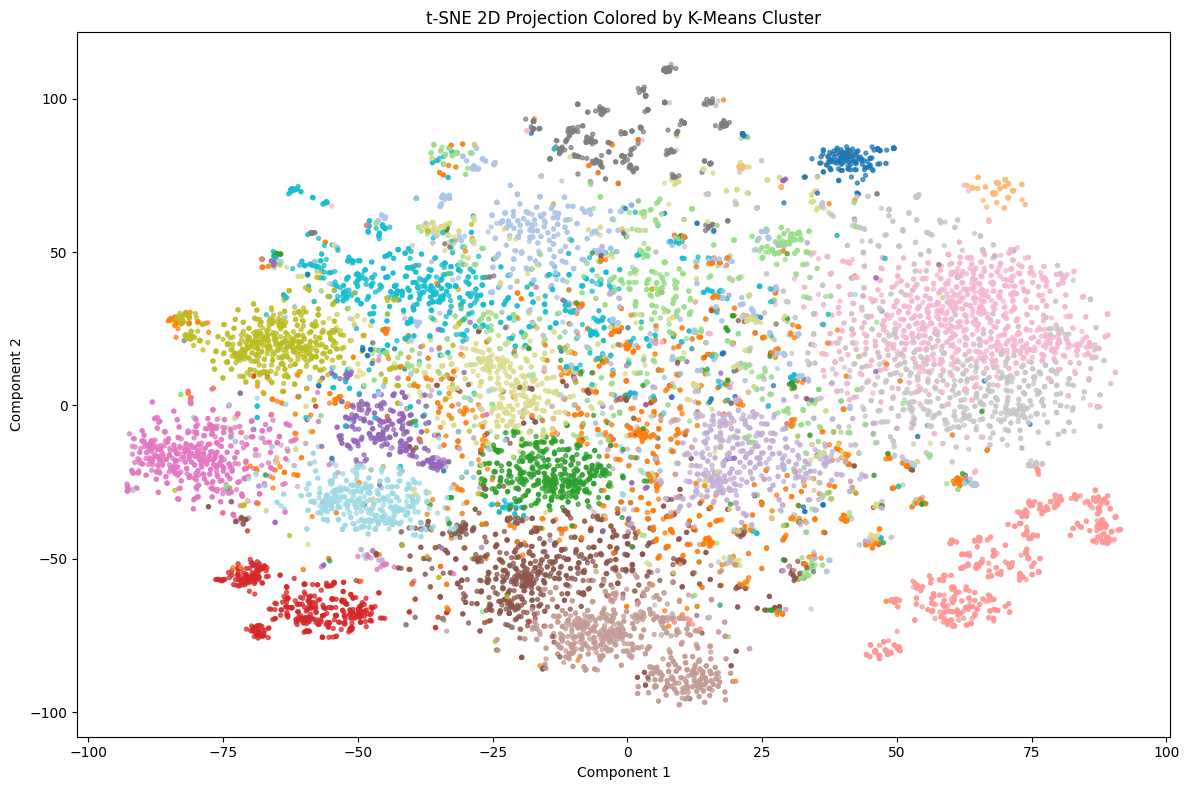

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1) Prepare data for visualization
X_viz = embeddings_pca if APPLY_PCA else embeddings_norm

# 2) t-SNE to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_2d = tsne.fit_transform(X_viz)

# Save for reuse
df_clusters["tsne_x"] = emb_2d[:, 0]
df_clusters["tsne_y"] = emb_2d[:, 1]

# 3) Plot K-Means clusters
plt.figure(figsize=(12, 8))
plt.scatter(
    df_clusters["tsne_x"], df_clusters["tsne_y"],
    c=df_clusters["kmeans_cluster"],
    cmap="tab20",
    s=8,
    alpha=0.7
)
plt.title("t-SNE 2D Projection Colored by K-Means Cluster")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()


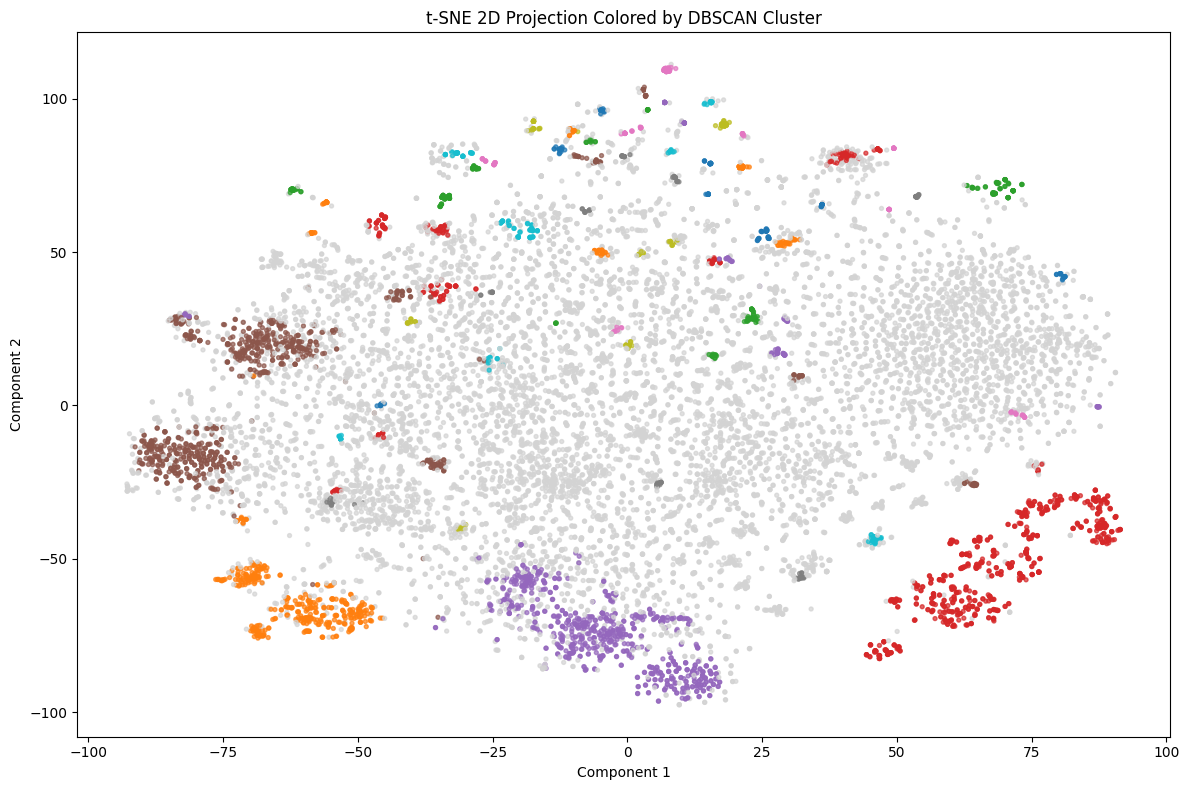

In [6]:
# 4) Plot DBSCAN clusters (noise = -1 in gray)
import matplotlib.colors as mcolors

# Assign color to each DBSCAN label, handle noise explicitly
dbscan_labels = df_clusters["dbscan_cluster"]
unique_labels = sorted(dbscan_labels.unique())
colors = [
    "lightgray" if label == -1 else plt.cm.tab10(label % 10)
    for label in dbscan_labels
]

plt.figure(figsize=(12, 8))
plt.scatter(
    df_clusters["tsne_x"], df_clusters["tsne_y"],
    c=colors,
    s=8,
    alpha=0.7
)
plt.title("t-SNE 2D Projection Colored by DBSCAN Cluster")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()


---

## Summary

Clustering applied to clause embeddings shows promising separation of legal themes using both K-Means and DBSCAN. Evaluation through silhouette scores and top clause types per cluster suggests that semantic embeddings capture meaningful legal distinctions.

These clusters may support downstream tasks like document classification, clause summarization, or search refinement.

---
